#### 构建一个可迭代的类来模拟一个村庄中，农民与工匠间的贸易：

基本假设：村民们每天需要消耗1份粮食，农民花0.3天并消耗一份工具就能产出一份粮食，但缺乏工具时生产效率会降低，不消耗工具时手刨粮食需要0.8天产出一份(因此将农民生产每份工具的时间近似为0.5天，且农民每天消耗种地时间量的工具)；

农民生产粮食，工具的时间消耗为[0.3, 0.5]；

工匠生产粮食，工具的时间消耗为[0.7, 0.2]。

因此每个村民都具有如下属性：

  生产属性，通过生产单位产品所需的时间衡量；
  
  消耗属性，每日消耗的产品份数；
  
  生产耗时，在生产某种产品上消耗的时间；
  
  贸易量，各商品的卖出，买入份数；
  
  库存状态，每天的(生产-消耗+贸易)量将被加入其中。越缺乏某种产品，越有动力去通过工作或贸易获得之。
  
先考虑不含贸易的类:
每一位村民的初始库存全部为0，他每天消耗在某项产品上的工作时长 = -库存 × 0.1 × 生产效率，

因此村民的产品消耗量为[1,农产品工作时长]

商品定价：每次交易计算 供需比例=(供应-需求)/(供应+需求),下次价格为 价格×EXP(供需比例)

购买行为：得知自己的优势商品后，购买所有值得的不容忍量，并希望出售等价值的商品

In [335]:
# 均值化以观察图像
import numpy as np
def moving_average(lst, k=5):
    arr = np.array(lst, dtype=float)
    n = len(arr)
    half = k // 2
    
    # 先创建一个全为原始数据的结果数组
    result = arr.copy()

    # 只在能够滑动的位置做滑动均值
    for i in range(half, n - half):
        result[i] = np.mean(arr[i - half:i + half + 1])

    return result

# 画图预备包
import matplotlib.pyplot as plt
Names = ["A's ", "B's ", "C's "];
Goods = ["food", "tools", "clothes", "gold"];
def fun_fianl(status, x, i, j):
    return [status[y][i][j] for y in x]
def visual(status, worktimes, prices = 0, k=20, names = Names, goods = Goods):
    if prices == 0:
        fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    else:
        fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    x=range(0,len(status))
    for i in range(len(status[0])):
        for j in range(len(status[0][1])):
            ax[0].plot(x, fun_fianl(status, x,i,j),label = names[i] + goods[j])
    ax[0].set_xlabel('Day')
    ax[0].set_ylabel('SVGtatus')
    ax[0].legend(loc='best')
    ax[0].grid()
    y = np.array(list(map(lambda x: np.sum(x, axis=1),worktimes))).T
    for i in range(len(y)):
        ax[1].plot(range(0,len(y[0])),moving_average(y[i], k), label = names[i])
    ax[1].set_xlabel('Day')
    ax[1].set_ylabel('Work Time')
    ax[1].legend(loc='best')
    ax[1].grid()
    if prices != 0:
        z = np.array(prices).T
        z = z / z[0] # 归一化以观察价格比例
        for i in range(len(z)):
            ax[2].plot(range(0,len(z[0])),z[i], label = names[i])
            ax[2].set_xlabel('Day')
            ax[2].set_ylabel('Goods Prices')
            ax[2].legend(loc='best')
            ax[2].grid()

In [325]:
import numpy as np
import copy
class IsoBlock(object): 
    def __init__(self, consumption, product_eff, status):
        """
        经济模拟系统中的独立无交易区块类。
        """
        # 读取参数，状态和工作时间
        self.consumption = np.array( consumption, dtype=float)  # 商品消耗量
        self.product_eff = np.array(product_eff, dtype=float)  # 单位时间能生产的商品量
        self.product_time = 1 / self.product_eff # 生产单位商品所需时间
        self.status = np.array(status, dtype=float)  # 库存状态
    
    def evolution(self, day):
        """
        经济演化过程。
        
        """
        # 计算每日工作时间（基于商品缺乏程度 * 耐受度（即1/5的工作时间，以保证库存在-5时单人独自能达到平衡））
#         self.worktime = (-self.status * 0.2) * self.product_time
#         self.worktime[self.worktime < 0] = 0
        self.coef = np.log(self.product_time) * (self.product_time) / day
        self.worktime = np.exp(self.coef * self.status)
        
        # 计算各职业每日生产量 = 生产工作时间 / 生产单位商品所需时间
        production = self.worktime * self.product_eff
        
        # 计算每日非必须品消耗（工具消耗即工作时间）
        self.consumption[:,1] = production[:,0]
        
        # 计算新库存状态：旧库存 + 生产 - 消耗 + 贸易变化
        self.status = self.status + production - self.consumption

In [337]:
# 创建实例
j=3; k=3;
Status = [];
Worktimes = [];
test = IsoBlock( 
               np.ones([j,k]), #201,纺 农 匠
               [[2.5, 2.5, 5],[5, 3.3, 3.3], [2.6, 10, 2.5]], 
               np.ones([j,k]) * 50)
for i in range(300):
    test.evolution(5)
    Status.append(test.status)
    Worktimes.append(test.worktime),test

In [338]:
# 参数检查
for attr, value in vars(test).items():
    print(f"{attr} = {value}")

consumption = [[1.         1.         1.        ]
 [1.         0.99999999 1.        ]
 [1.         1.         1.        ]]
product_eff = [[ 2.5  2.5  5. ]
 [ 5.   3.3  3.3]
 [ 2.6 10.   2.5]]
product_time = [[0.4        0.4        0.2       ]
 [0.2        0.3030303  0.3030303 ]
 [0.38461538 0.1        0.4       ]]
status = [[12.50000003 12.50000111 25.00000014]
 [25.00000014 16.50000122 16.50000003]
 [13.00000002 50.00026676 12.50000003]]
coef = [[-0.07330326 -0.07330326 -0.06437752]
 [-0.06437752 -0.07235894 -0.07235894]
 [-0.07350088 -0.0460517  -0.07330326]]
worktime = [[0.4        0.39999996 0.2       ]
 [0.2        0.30303027 0.3030303 ]
 [0.38461538 0.09999871 0.4       ]]


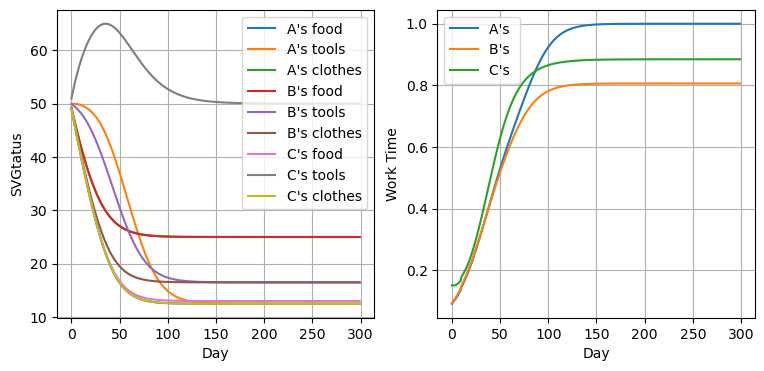

In [339]:
visual(Status, Worktimes)

In [329]:
import numpy as np
import copy
class TradeBlock(IsoBlock): 
    def __init__(self, consumption, product_time, status, currency, trade_prices):
        """
        经济模拟系统中的有贸易区块类。
        """
        # 读取参数，状态和工作时间
        super().__init__(consumption, product_time, status)
        self.currency = np.array(currency, dtype=float) # 各职业手中的资产
        self.trade_prices = np.array(trade_prices, dtype=float) # 商品的市场价格
        # 给出演化中不变但需要用到的常参数
        self.category = len(trade_prices) # 商品种数
        self.N = len(status) # 职业数
        self.x = range(self.N)
        self.swift = []
        self.voidm = np.zeros_like(self.status)
        
        self.preworktime = 0 #初始化抑制参数
    
    def evolution(self, day, test): #day: 仓储容量，day = 10即有能用10天的货物
        """
        经济演化过程。
        
        """
        # 计算各职业的体感价格(生产某商品时赚取单位价值所需的时间，并倾向于生产效率最高的产品)
        self.feel_price = self.product_eff * self.trade_prices
        # 找到对某职业相对最优势的商品序号
        self.choice = np.array(np.argmax(self.feel_price, axis=1),dtype=int)
        
        #计算各职业每日拟购买的各商品量
        self.needs = np.exp(-self.status / day + 1) #购买所有商品,库存越多想买的越少，平衡于仓储容量
        self.needs[range(self.N), self.choice] = 0 #但不买自身的优势商品
        #对所有职业求和得到各商品量的需求量
        self.need = np.sum(self.needs, axis=0)
        #计算在市场上拟支出的金额（商品消耗量 × 商品价值）
        self.expend = self.needs * self.trade_prices
        #计算在市场上拟出售的(优势)商品数量
        self.sell = np.sum(self.expend, axis=1) / self.trade_prices[self.choice]
        #计算各商品的供应量
        self.provide = np.zeros(self.category)
        np.add.at(self.provide, self.choice, self.sell) #找出某职业售卖量（sell）的商品种类（choice）
        
        # 各职业被满足的需求量
        self.filled = self.provide + 0 # +0以免干扰原指标
        self.filled[self.filled > self.need] = self.need[self.filled > self.need] # 削去过量供给
        # 各职业卖出的商品量
        self.presold = self.need + 0 # +0以免干扰原指标
        self.presold[self.presold > self.provide] = self.provide[self.presold > self.provide] # 削去过量需求
        self.sold = np.zeros_like(self.status) 
        self.sold[np.arange(len(self.choice)), self.choice] = self.presold[self.choice] #将售卖量放入状态（status）中
        
        # 计算每日工作时间（基于商品缺乏程度 * 耐受度（即1/5的工作时间，以保证库存在-5时单人独自能达到平衡））
        self.worktime = (1 - self.status * 2 / day) * self.product_time #存货不到仓储容量的一半时开始自己动手生产
        self.worktime[self.worktime < 0] = 0 #仓储够时不生产
        coef = np.log(self.product_time[self.x, self.choice]) * (self.product_time[self.x, self.choice]) / day
        self.worktime[self.x, self.choice] = np.exp(coef * self.status[self.x, self.choice])
        r=0.7
        self.worktime = (self.worktime * r + self.preworktime * (1-r))
        self.preworktime = self.worktime
        
        # 计算各职业每日生产量 = 生产工作时间 / 生产单位商品所需时间
        production = self.worktime * self.product_eff
        
        # 计算每日非必须品消耗（工具消耗即工作时间） 
#         self.consumption[:,1] = production[:,0] #由于种田消耗工具将导致种田成本变化，影响优势商品的选取，故先不实装以测试平衡
        
        # 计算总劳动负担（每个职业的工作时间总和）
        loading = np.sum(self.worktime, axis=1)
        
        # 计算新库存状态：旧库存 + 生产 - 消耗 + 贸易变化
        self.status = self.status + production - self.consumption
        if test == 0:
            self.status_test =  self.status + self.filled - self.sold
        else:
            self.status = self.status + self.filled - self.sold
        # 计算货币流动
#         print(self.sold,self.filled)
        self.exchange = np.sum((self.sold - self.filled)  * self.trade_prices, axis=1)
#         print(self.currency, self.exchange)
        self.currency += self.exchange
#         self.swift.append([self.exchange, self.currency])
        
        # 加权供需比例作为调整价格的基数
        self.change = (self.need - self.provide) / (self.need + self.provide)
        if test == 0:
            self.trade_test = self.trade_prices * np.exp(self.change * 0.2)
        else:
            self.trade_prices = self.trade_prices * np.exp(self.change * 0.02)

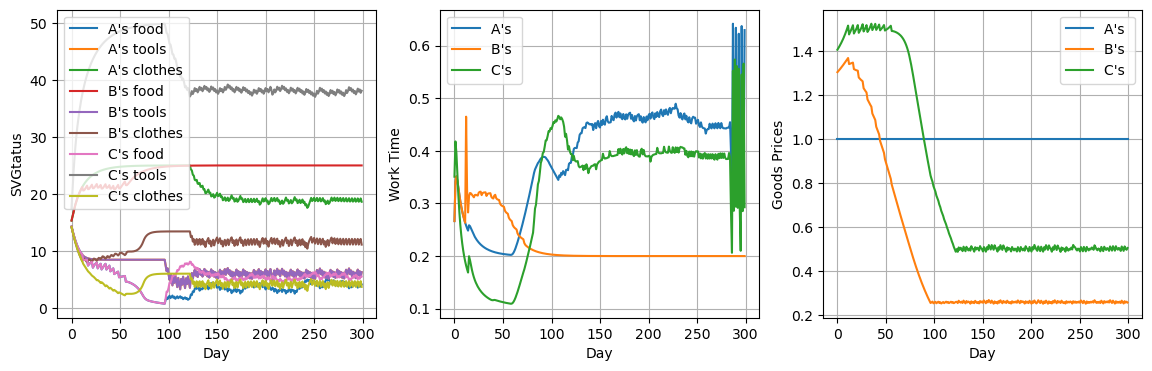

In [342]:
# 创建实例
j=3; k=3;
Status = [];
Worktimes = [];
Prices = [];
test = TradeBlock( 
               np.ones([j,k]), #201,纺 农 匠
               [[2.5, 2.5, 5],[5, 3.3, 3.3], [2.6, 10, 2.5]], 
               np.ones([j,k]) * 15, 
               np.zeros(j),
               [1,1.3,1.4])
for i in range(300):
    test.evolution(5, 1)
    Status.append(test.status)
    Worktimes.append(test.worktime)
    Prices.append(test.trade_prices)
visual(Status, Worktimes, Prices, 30)

In [225]:
test.need

array([0.31317694, 0.29072446, 0.25785924])

In [226]:
test.provide

array([0.31317694, 0.29072446, 0.25785924])

In [232]:
prices = np.array(Prices)
what = prices / prices[:, 0].reshape(-1, 1)
print(what)

[[1.         1.30492163 1.40693242]
 [1.         1.30999995 1.41419821]
 [1.         1.31524326 1.4218383 ]
 [1.         1.32065791 1.42989804]
 [1.         1.3262471  1.43842711]
 [1.         1.33200958 1.44747949]
 [1.         1.3379382  1.45711345]
 [1.         1.34401838 1.46739171]
 [1.         1.35022661 1.47838191]
 [1.         1.35652903 1.49015739]
 [1.         1.3628801  1.50279854]
 [1.         1.36922138 1.51639453]
 [1.         1.34157161 1.47630652]
 [1.         1.34320406 1.48572004]
 [1.         1.34475351 1.4954009 ]
 [1.         1.34650371 1.5061156 ]
 [1.         1.34848619 1.51810884]
 [1.         1.31897761 1.48045315]
 [1.         1.31654662 1.48833934]
 [1.         1.3144483  1.49701954]]


In [224]:
# 参数检查
for attr, value in vars(test).items():
    print(f"{attr} = {value}")

consumption = [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
product_eff = [[ 2.5  2.5  5. ]
 [ 5.   3.3  3.3]
 [ 2.6 10.   2.5]]
product_time = [[0.4        0.4        0.2       ]
 [0.2        0.3030303  0.3030303 ]
 [0.38461538 0.1        0.4       ]]
status = [[13.58384751 13.54057422 16.03665701]
 [16.03665701 13.54057422 13.48019577]
 [13.58384751 20.68639252 13.48019577]]
currency = [-1.28659399 -1.37502056 -1.25612159]
trade_prices = [1.  1.3 1.4]
category = 3
N = 3
x = range(0, 3)
swift = []
voidm = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
preworktime = [[0.         0.         0.34081985]
 [0.34081985 0.         0.        ]
 [0.         0.41780819 0.        ]]
feel_price = [[ 2.5   3.25  7.  ]
 [ 5.    4.29  4.62]
 [ 2.6  13.    3.5 ]]
choice = [2 0 1]
needs = [[0.15658847 0.15724189 0.        ]
 [0.         0.15724189 0.15810952]
 [0.15658847 0.         0.15810952]]
need = [0.31317694 0.29072446 0.25785924]
expend = [[0.15658847 0.20441446 0.        ]
 [0.         0.20441446 0.22135333]
 [0

In [134]:
a = [range(len(couple.choice)),couple.choice]
couple.status[a[0],a[1]]
couple.status

array([[ 1.06338240e-04, -1.33741810e+02,  9.93394149e+00],
       [ 1.06338240e-04,  9.95172576e+00, -8.80518223e+01],
       [ 1.06338240e-04,  9.95172576e+00, -8.76263105e+01]])

In [63]:
sum(couple.currency)

0.0

In [59]:
# 参数检查
for attr, value in vars(couple).items():
    print(f"{attr} = {value}")

consumption = [[1.         0.99826633 1.        ]
 [1.         0.99826633 1.        ]
 [1.         0.99826633 1.        ]]
product_time = [[0.4 0.4 0.2]
 [0.2 0.3 0.3]
 [0.4 0.1 0.4]]
status = [[0.01561808 0.08637209 0.01561808]
 [0.01561808 0.08637209 0.01561808]
 [0.01561808 0.08637209 0.01561808]]
N = 3
currency = [  5.42769106 -26.12321637  20.69552532]
trade_prices = [1.  1.3 1.4]
swift = [[array([ 0.18096748, -0.63338619,  0.45241871]), array([  5.42769106, -26.12321637,  20.69552532])], [array([ 0.16020324, -0.62819513,  0.46799189]), array([  5.42769106, -26.12321637,  20.69552532])], [array([ 0.14319083, -0.6244511 ,  0.48126027]), array([  5.42769106, -26.12321637,  20.69552532])], [array([ 0.12947092, -0.62195226,  0.49248133]), array([  5.42769106, -26.12321637,  20.69552532])], [array([ 0.11863045, -0.62051947,  0.50188902]), array([  5.42769106, -26.12321637,  20.69552532])], [array([ 0.11029782, -0.61999364,  0.50969582]), array([  5.42769106, -26.12321637,  20.69552532]

In [60]:
import numpy as np
import copy
class Block1(object): 
    def __init__(self, consumption, product_time, status, currency, trade_prices):
        """
        经济模拟系统中的区块（Block1）类。
        
        参数：
        - n: 区块中职业种类数
        - csp: 消费矩阵（职业数量 × 商品种类），表示各职业人口的商品消耗量
        - p_t: 生产时间矩阵（职业数量 × 商品种类），表示生产一单位商品所需时间
        - sts: 状态张量（时间 × 职业数量 × 商品种类），表示库存状态
        - wts: 工作时间张量（时间 × 职业数量 × 商品种类），表示每日生产所花费的时间
        - tps: 商品基准价格列表
        """
        # 读取参数，状态和工作时间
        self.consumption = np.array( consumption, dtype=float)  # 商品消耗量
        self.product_time = np.array(product_time, dtype=float)  # 生产单位商品所需时间
        self.status = np.array(status, dtype=float)  # 库存状态
        self.currency = np.array(currency, dtype=float) # 商品的市场价格
        self.trade_prices = np.array(trade_prices, dtype=float) # 商品的市场价格
        
        self.swift = []
        self.category = len(trade_prices) # 商品种类的数目
        self.N = len(status) # 职业数
    
    def evolution(self, test):
        """
        经济演化过程。
        """
        # 计算各职业的体感价格(生产某商品时赚取单位价值所需的时间，并倾向于生产效率最高的产品)
        self.feel_price = self.product_time / self.trade_prices
        # 找到对某职业相对最优势的商品序号
        self.choice = np.array(np.argmin(couple.feel_price, axis=1),dtype=int)
        
        #计算各职业每日拟购买的各商品量
        self.needs = -self.status * 0.2 * 2#购买所有商品,库存越少想买越多）
        self.needs[range(self.N), self.choice] = 0 #但不买优势商品
        #对所有职业求和得到各商品量的需求量
        self.need = np.sum(self.needs, axis=0)
        #计算在市场上拟支出的金额（商品消耗量 × 商品价值）
        self.expend = self.needs * self.trade_prices
        #计算在市场上拟出售的(优势)商品数量
        self.sell = np.sum(self.expend, axis=1) / self.trade_prices[self.choice]
        #计算各商品的供应量
        self.provide = np.zeros(self.category)
        np.add.at(self.provide, self.choice, self.sell) #找出某职业售卖量（sell）的商品种类（choice）
        
        # 供需比例
        self.ndp = self.provide / self.need
        self.ndp[self.ndp > 1] = 1 #削去过量供应
        # 各职业被满足的需求量
        self.filled = self.needs * self.ndp #以计算真实的购买量
        # 需供比例
        self.pdn = self.need / self.provide
        self.pdn[self.pdn > 1] = 1 #削去过量需求
        # 各职业卖出的商品量
        self.presold = self.provide * self.pdn #以计算真实的出售量
        self.sold = np.zeros_like(self.status) 
        self.sold[np.arange(len(self.choice)), self.choice] = self.presold[self.choice] #将售卖量放入状态（status）中
        # 计算每日工作时间（基于商品缺乏程度 * 耐受度（即1/5的工作时间，以保证库存在-5时单人独自能达到平衡））
        if test == 0:
            self.worktime = (-self.status * 0.2 - 0) * self.product_time
            self.worktime_test = (-self.status * 0.2 - self.filled) * self.product_time
            self.worktime_test[self.worktime_test < 0] = 0
        else:
            self.worktime = (-self.status * 0.2 - self.filled) * self.product_time
            self.worktime[self.worktime < 0] = 0
        
        # 计算各职业每日生产量 = 生产工作时间 / 生产单位商品所需时间
        production = self.worktime / self.product_time
        
        # 计算每日非必须品消耗（工具消耗即工作时间）
        self.consumption[:,1] = production[:,0]
        
        # 计算总劳动负担（每个职业的工作时间总和）
        loading = np.sum(self.worktime, axis=1)
        
        # 计算新库存状态：旧库存 + 生产 - 消耗 + 贸易变化
        self.status = self.status + production - self.consumption
        self.status_test = [self.filled * self.trade_prices, self.sold * self.trade_prices]
        # 计算货币流动
        self.exchange = np.sum((self.sold - self.filled)  * self.trade_prices, axis=1)
        self.currency = self.currency + self.exchange
        self.swift.append([self.exchange, self.currency])
        
        # 加权供需比例作为调整价格的基数
        self.change = (self.need - self.provide) / (self.need + self.provide)
        if test == 0:
            self.trade_test = self.trade_prices * np.exp(self.change * 0.2)
        else:
            self.trade = self.trade_prices * np.exp(self.change * 0.2)

In [61]:
# 创建实例
j=3; k=3;
Status = [];
Worktimes = [];
couple = TradeBlock( 
               np.ones([j,k]), #201,纺 农 匠
               [[0.4, 0.4, 0.2],[0.2, 0.3, 0.3], [0.4, 0.1, 0.4]], 
               -np.ones([j,k]), 
               np.zeros(j),
               [1,1.3,1.4])
for i in range(60):
    couple.evolution(0)
    Status.append(couple.status)
    Worktimes.append(couple.worktime),

[[0.         0.         3.63127587]
 [4.42068367 0.         0.        ]
 [0.         4.08063108 0.        ]] [[2.21034184 2.04031554 0.        ]
 [0.         2.04031554 1.81563794]
 [2.21034184 0.         1.81563794]]
[[0.         0.         3.61475834]
 [4.37443457 0.         0.        ]
 [0.         4.0379396  0.        ]] [[2.18721728 2.0189698  0.        ]
 [0.         2.0189698  1.80737917]
 [2.18721728 0.         1.80737917]]
[[0.         0.         3.59783037]
 [4.33367714 0.         0.        ]
 [0.         4.00031736 0.        ]] [[2.16683857 2.00015868 0.        ]
 [0.         2.00015868 1.79891519]
 [2.16683857 0.         1.79891519]]
[[0.         0.         3.58077975]
 [4.29767628 0.         0.        ]
 [0.         3.9670858  0.        ]] [[2.14883814 1.9835429  0.        ]
 [0.         1.9835429  1.79038988]
 [2.14883814 0.         1.79038988]]
[[0.         0.         3.56383896]
 [4.26581209 0.         0.        ]
 [0.         3.93767269 0.        ]] [[2.13290604 1.9688

In [ ]:
# 参数检查
for attr, value in vars(couple).items():
    print(f"{attr} = {value}")

粮食价格较低，工具价格适中，衣服价格较高，
造成粮食求过于供，工具刚好平衡，衣服供过于求.
既需要生产截断阻止能买到的商品的再生产，又需要放大购买欲望，超过需求量，以达到提高库存压缩购买欲望的目的

In [ ]:
import matplotlib.pyplot as plt
names = ["A's ", "B's ", "C's "];
goods = ["food", "tools", "clothes", "gold"];
final = Status
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

x=range(0,len(final))
def fun_fianl(x,i,j):
    return [final[y][i][j] for y in x]
for i in range(len(final[0])):
    for j in range(len(final[0][1])):
        ax[0].plot(x, fun_fianl(x,i,j),label = names[i] + goods[j])
ax[0].set_xlabel('Day')
ax[0].set_ylabel('status')
ax[0].legend(loc='best')
ax[0].grid()
y = np.array(list(map(lambda x: np.sum(x, axis=1),Worktimes))).T
for i in range(len(y)):
    ax[1].plot(x,y[i], label = names[i])
ax[1].set_xlabel('Day')
ax[1].set_ylabel('Worktime')
ax[1].legend(loc='best')
ax[1].grid()

In [ ]:

        
        参数：
        - n: 区块中职业种类数
        - consumption: 消费矩阵（职业数量 × 商品种类），表示各职业人口的商品消耗量
        - production_time: 生产时间矩阵（职业数量 × 商品种类），表示生产一单位商品所需时间
        - status: 状态张量（时间 × 职业数量 × 商品种类），表示库存状态